In [1]:
import sqlite3
import pandas as pd

def get_warehouse_inventory(warehouse_id):
    conn = sqlite3.connect("inventory_management.db")
    query = """
    SELECT 
        w.name as warehouse_name,
        p.name as product_name,
        p.category,
        i.current_stock,
        p.reorder_point,
        (SELECT SUM(quantity)
            FROM sales s
            WHERE s.warehouse_id = w.warehouse_id
            AND s.product_id = p.product_id
            AND s.sale_date >= date('now', '-30 days')
        ) as monthly_sales
    FROM inventory i
    JOIN warehouses w ON i.warehouse_id = w.warehouse_id
    JOIN products p ON i.product_id = p.product_id
    WHERE w.warehouse_id = ?
    """
    
    df = pd.read_sql(query, conn, params = [warehouse_id])
    conn.close()
    
    return df

In [2]:
get_warehouse_inventory(1)

,warehouse_name,product_name,category,current_stock,reorder_point,monthly_sales
0,North Hub,Laptop Pro,Electronics,45,50,62
1,North Hub,Smartphone X,Electronics,80,75,66
2,North Hub,Wireless Earbuds,Electronics,95,100,15


In [29]:
get_warehouse_inventory(2)

,warehouse_name,product_name,category,current_stock,reorder_point,monthly_sales
0,Central Distribution,Laptop Pro,Electronics,55,50,55
1,Central Distribution,Smartphone X,Electronics,65,75,52
2,Central Distribution,Smart Watch,Electronics,58,60,17


In [30]:
get_warehouse_inventory(3)

,warehouse_name,product_name,category,current_stock,reorder_point,monthly_sales
0,East Coast Center,Wireless Earbuds,Electronics,85,100,57
1,East Coast Center,Smart Watch,Electronics,52,60,25
2,East Coast Center,Tablet Ultra,Electronics,35,40,28


In [3]:
def get_all_warehouses():
    conn = sqlite3.connect("inventory_management.db")
    df = pd.read_sql("SELECT * FROM warehouses", conn)
    conn.close()
    
    return df.warehouse_id.tolist()
    

In [4]:
get_all_warehouses()

[1, 2, 3]

In [21]:
from typing import TypedDict, Annotated
from operator import add

class State(TypedDict):
    warehouses: list
    recommendations: Annotated[list, add]
    final_plan: str
    next: list

class WarehouseState(TypedDict):
    warehouse_id: int

In [31]:
def analyze_warehouse(state: WarehouseState):
    df = get_warehouse_inventory(state["warehouse_id"])
    
    recommendations = []
    
    for _,row in df.iterrows():
        monthly_sales = row["monthly_sales"] if row["monthly_sales"] else 0
        if row["current_stock"] < row["reorder_point"]:
            recommendations.append(
                f'URGENT: Restock {row["product_name"]} at {row["warehouse_name"]}'
                f'Current Stock: {row["current_stock"]}, Reorder point: {row["reorder_point"]}'
            )
        elif row["current_stock"] <= monthly_sales:
            recommendations.append(
                f'WARNING: Low stock for {row["product_name"]} at {row["warehouse_name"]}'
                f'Current Stock {row["current_stock"]} is below monthly sales {monthly_sales}'
            )
            
    return {"recommendations": recommendations}
    

In [26]:
def create_final_plan(state: State):
    recommendations = state["recommendations"]
    urgent_items = [r for r in recommendations if r.startswith("URGENT")]
    warning_items = [r for r in recommendations if r.startswith("WARNING")]
    
    final_plan = "Priority Restocking Plan:\n\n"
    final_plan += "URGENT ACTIONS:\n" + "\n".join(urgent_items) + "\n\n"
    final_plan += "WARNINGS:\n" + "\n".join(warning_items)
    
    return {"final_plan": final_plan}

In [13]:
from langgraph.types import Send
def continue_to_analysis(state: State):
    warehouses = get_all_warehouses()
    
    sends = [Send("analyze_warehouse", {"warehouse_id": w}) for w in warehouses]
    return {
        "warehouses": warehouses,
        "next": sends
    }    

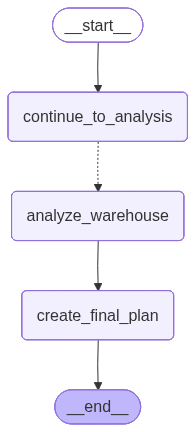

In [32]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image

flow = StateGraph(state_schema=State)
flow.add_node("analyze_warehouse", analyze_warehouse)
flow.add_node("create_final_plan", create_final_plan)
flow.add_node("continue_to_analysis", continue_to_analysis)

flow.add_edge(START, "continue_to_analysis")
flow.add_conditional_edges("continue_to_analysis", lambda state: state["next"], ["analyze_warehouse"])
flow.add_edge("analyze_warehouse", "create_final_plan")
flow.add_edge("create_final_plan", END)

graph = flow.compile()
Image(graph.get_graph().draw_mermaid_png())

In [33]:
result = graph.invoke({})
print(result["final_plan"])

Priority Restocking Plan:

URGENT ACTIONS:
URGENT: Restock Laptop Pro at North HubCurrent Stock: 45, Reorder point: 50
URGENT: Restock Wireless Earbuds at North HubCurrent Stock: 95, Reorder point: 100
URGENT: Restock Smartphone X at Central DistributionCurrent Stock: 65, Reorder point: 75
URGENT: Restock Smart Watch at Central DistributionCurrent Stock: 58, Reorder point: 60
URGENT: Restock Wireless Earbuds at East Coast CenterCurrent Stock: 85, Reorder point: 100
URGENT: Restock Smart Watch at East Coast CenterCurrent Stock: 52, Reorder point: 60
URGENT: Restock Tablet Ultra at East Coast CenterCurrent Stock: 35, Reorder point: 40

WARNINGS:
